In [ ]:
%pip install ultralytics --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.6 MB/s eta 0:00:00


In [ ]:
import os
import ultralytics
from PIL import Image
import json
import time
from ultralytics import YOLO
from IPython.display import display, Image as IPImage
import shutil
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
ultralytics.checks()

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/107.7 GB disk)


In [ ]:
#### In Case of Mount Fail In The First Run - Run Again
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Intro to computer vision/Final/train_validation_images"
assert os.path.exists(DATASET_PATH), "Dataset path not found!"

In [ ]:
dataset_yaml_path = os.path.join(DATASET_PATH, "dataset.yaml")

with open(dataset_yaml_path, "w") as f:
    f.write(f"""\
train: {os.path.join(DATASET_PATH, "train")}
val: {os.path.join(DATASET_PATH, "validation")}
nc: 2
names: ['person','pet']
""")

print(f"`dataset.yaml` created at: {dataset_yaml_path}")

`dataset.yaml` created at: /content/drive/MyDrive/Intro to computer vision/Final/train_validation_images/dataset.yaml


In [ ]:
################################ CREATING THE .txt FILES - NO NEED TO RE-RUN THIS PART ################################

label_map = {"person": 0, "pet": 1}  # consistent with dataset.yaml

def convert_bbox_to_yolo(bbox, img_w, img_h):
    x1, y1, x2, y2 = bbox
    x_center = ((x1 + x2) / 2) / img_w
    y_center = ((y1 + y2) / 2) / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return x_center, y_center, width, height

splits = ['train', 'validation']

for split in splits:
    for cls in ['person', 'pet']:
        folder_path = os.path.join(DATASET_PATH, split, cls)
        for file in os.listdir(folder_path):
            if file.endswith(".json"):
                json_path = os.path.join(folder_path, file)
                img_path = json_path.replace(".json", ".jpg")

                try:
                    with open(json_path, 'r') as f:
                        annotation = json.load(f)
                    img = Image.open(img_path)
                    img_w, img_h = img.size

                    yolo_lines = []
                    for label, bbox in zip(annotation["labels"], annotation["bboxes"]):
                        if label not in label_map:
                            continue
                        class_id = label_map[label]
                        yolo_box = convert_bbox_to_yolo(bbox, img_w, img_h)
                        yolo_line = f"{class_id} {' '.join(map(str, yolo_box))}"
                        yolo_lines.append(yolo_line)

                    # Write YOLO label file
                    label_path = img_path.replace(".jpg", ".txt")
                    with open(label_path, 'w') as out_f:
                        out_f.write("\n".join(yolo_lines))

                except Exception as e:
                    print(f" Skipping {json_path} due to error: {e}")

In [ ]:
################################ FIRST TRAINING OF THE MODEL, THE MODEL WAS SAVED TO DRIVE - NO NEED TO RE-RUN THIS PART ################################

DATASET_PATH = "/content/drive/MyDrive/Intro to computer vision/Final/train_validation_images"
dataset_yaml_path = os.path.join(DATASET_PATH, "dataset.yaml")

# Define model variant
MODEL_SIZE = 'n'  # 'n', 's', 'm', 'l', or 'x'

model = YOLO(f'yolov8{MODEL_SIZE}.pt')  # load pretrained model
TRAIN_NAME = "yolov8_first_training"

SAVE_TO_DRIVE_PATH = f"/content/drive/MyDrive/Intro to computer vision/Final/{TRAIN_NAME}_best.pt"

start_time = time.time()
model.train(
    data=dataset_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    name=TRAIN_NAME,
    cache=True,
    device=0,     # Use GPU if available
)
end_time = time.time()
print(f"Training finished in {round(end_time - start_time, 2)} seconds.")

best_model_path = f"runs/detect/{TRAIN_NAME}/weights/best.pt"
if os.path.exists(best_model_path):
    shutil.copy(best_model_path, SAVE_TO_DRIVE_PATH)  # Save best model to Drive
    print(f"Model saved to: {SAVE_TO_DRIVE_PATH}")
else:
    print("Training completed, but best.pt not found.")

# **Explaining the performance after first training:**

---

####The YOLOv8n model was trained for 50 epochs on a dataset of 1200 annotated images (1000 for training, 200 for validation) containing two classes: person and pet.
####The final evaluation results on the validation set show a precision of 0.859, recall of 0.667, mAP50 of 0.774, and mAP50-95 of 0.560. Individually, the model performed slightly better on the pet class, achieving a precision of 0.905 and mAP50-95 of 0.602, compared to 0.814 and 0.518 respectively for the person class.
####These results indicate that the model learned the task effectively, demonstrating strong precision (few false positives) and moderate recall (some missed detections).
####Overall, the model exhibits solid performance considering the relatively small dataset size, lightweight architecture, and absence of custom augmentations, which will be addressed in the next training phase.

The following augmentations were based on the information given in this article:

https://medium.com/internet-of-technology/yolov8-best-practices-for-training-cdb6eacf7e4f

Additionally, the information about how each augmentation affects the training process is detailed in the article.

We have changed some of those values to see how the affect the model's behaviour

In [ ]:
# ############################### SECOND TRAINING OF THE MODEL, WITH AUGMENTATIONS, THE MODEL WAS SAVED TO DRIVE - NO NEED TO RE-RUN THIS PART ################################

DATASET_PATH = "/content/drive/MyDrive/Intro to computer vision/Final/train_validation_images"
dataset_yaml_path = os.path.join(DATASET_PATH, "dataset.yaml")
SAVE_TO_DRIVE_PATH = "/content/drive/MyDrive/Intro to computer vision/Final/yolov8_augmented_training_best.pt"

MODEL_SIZE = 'n'
model = YOLO(f'yolov8{MODEL_SIZE}.pt')
TRAIN_NAME = "yolov8_augmented_training"
EPOCHS = 50

start_time = time.time()

model.train(
    data=dataset_yaml_path,
    epochs=EPOCHS,
    imgsz=640,
    batch=16,
    name=TRAIN_NAME,
    device=0,
    cache=True,

    # AUGMENTATIONS
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=10.0, translate=0.1, scale=0.5, shear=2.0,
    perspective=0.0005,
    fliplr=0.5,
    erasing=0.4,
    mosaic=1.0,
    mixup=0.1,
    copy_paste=0.2,
)

end_time = time.time()
print(f"Training finished in {round(end_time - start_time, 2)} seconds.")

best_model_path = f"runs/detect/{TRAIN_NAME}/weights/best.pt"
if os.path.exists(best_model_path):
    shutil.copy(best_model_path, SAVE_TO_DRIVE_PATH)
    print(f"Best model saved to: {SAVE_TO_DRIVE_PATH}")
else:
    print("Training completed but best.pt not found.")

In [ ]:
################################ THIRD TRAINING OF THE MODEL, WITH OTHER AUGMENTATIONS, THE MODEL WAS SAVED TO DRIVE - NO NEED TO RE-RUN THIS PART ################################

DATASET_PATH = "/content/drive/MyDrive/Intro to computer vision/Final/train_validation_images"
dataset_yaml_path = os.path.join(DATASET_PATH, "dataset.yaml")
SAVE_TO_DRIVE_PATH = "/content/drive/MyDrive/Intro to computer vision/Final/yolov8_small_augmented_best.pt"

MODEL_SIZE = 's'  # model variant changed to small
model = YOLO(f'yolov8{MODEL_SIZE}.pt')
TRAIN_NAME = "yolov8_small_augmented_best"
EPOCHS = 50

start_time = time.time()

model.train(
    data=dataset_yaml_path,
    epochs=EPOCHS,
    imgsz=640,
    batch=16,
    name=TRAIN_NAME,
    device=0,
    cache=True,

    # AUGMENTATIONS
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.4,
    translate=0.2,
    scale=0.5,
    shear=0.01,
    perspective=0.001,
    flipud=0.3,
    fliplr=0.3,
    erasing=0.4,
    mosaic=0.5,
    mixup=0.3,
    copy_paste=0.3,
    crop_fraction=0.3,
)

end_time = time.time()
print(f"Training finished in {round(end_time - start_time, 2)} seconds.")

best_model_path = f"runs/detect/{TRAIN_NAME}/weights/best.pt"
if os.path.exists(best_model_path):
    shutil.copy(best_model_path, SAVE_TO_DRIVE_PATH)
    print(f"Best model saved to: {SAVE_TO_DRIVE_PATH}")
else:
    print("Training completed but best.pt not found.")

# **Explain thoughts and insight through the training process:**

---

####Throughout the training process, we began by training the YOLOv8n model on the Florence-2 annotated dataset without any custom augmentations.This baseline model performed well, especially in detecting the “pet” class, with mAP50 reaching 0.774 and mAP50-95 at 0.560.
####To improve generalization, we retrained the model using augmentations such as flipping, brightness adjustment, shearing, and mixup. These additions helped the model become more adaptable to different visual scenarios, slightly increasing mAP50 to 0.778, though mAP50-95 dropped to 0.528, indicating slightly reduced fine-grained accuracy.
####In a second experiment, we switched to the larger YOLOv8s model (11M parameters vs. 3M) and used a new augmentation set. While recall improved (0.711 vs. 0.677) and mAP50-95 rose to 0.548, precision dropped slightly (from 0.844 to 0.753), likely due to more false positives.
####These experiments highlighted the trade-offs between model complexity, augmentation strategy, and performance metrics, demonstrating that different configurations offer different strengths depending on the specific goals of detection accuracy and robustness.

#Inference on a single image for all models

Selected image: /content/drive/MyDrive/Intro to computer vision/Final/train_validation_images/validation/pet/7677138150.jpg

image 1/1 /content/drive/MyDrive/Intro to computer vision/Final/train_validation_images/validation/pet/7677138150.jpg: 448x640 5 persons, 1 pet, 345.2ms
Speed: 10.7ms preprocess, 345.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict85

image 1/1 /content/drive/MyDrive/Intro to computer vision/Final/train_validation_images/validation/pet/7677138150.jpg: 448x640 3 persons, 1 pet, 158.0ms
Speed: 3.2ms preprocess, 158.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict86

image 1/1 /content/drive/MyDrive/Intro to computer vision/Final/train_validation_images/validation/pet/7677138150.jpg: 448x640 4 persons, 1 pet, 479.3ms
Speed: 3.3ms preprocess, 479.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict87
Mo

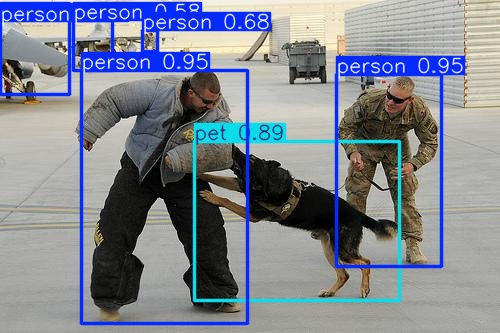

Model trained WITH augmentations:


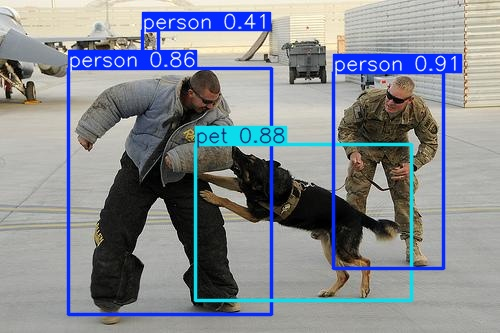

Model trained WITH more parameters(YOLOv8-small):


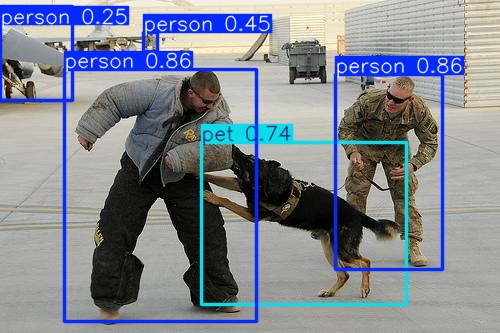

In [ ]:
model_plain_path = "/content/drive/MyDrive/Intro to computer vision/Final/yolov8_first_training_best.pt"
model_nano_path = "/content/drive/MyDrive/Intro to computer vision/Final/yolov8_augmented_training_best.pt"
model_small_path = "/content/drive/MyDrive/Intro to computer vision/Final/yolov8_small_augmented_best.pt"

model_plain = YOLO(model_plain_path)
model_aug_nano  = YOLO(model_nano_path)
model_aug_small = YOLO(model_small_path)

# pick a random image from validation
all_validation_images = []
for cls in ["pet", "person"]:
    folder = os.path.join(DATASET_PATH, "validation", cls)
    all_validation_images.extend([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".jpg")])

selected_image = random.choice(all_validation_images)
print("Selected image:", selected_image)

results_plain = model_plain(selected_image, save=True)
results_aug_nano = model_aug_nano(selected_image, save=True)
results_aug_small = model_aug_small(selected_image, save=True)

output_plain = os.path.join(results_plain[0].save_dir, os.path.basename(selected_image))
output_aug_nano = os.path.join(results_aug_nano[0].save_dir, os.path.basename(selected_image))
output_aug_small = os.path.join(results_aug_small[0].save_dir, os.path.basename(selected_image))

print("Model trained WITHOUT augmentations:")
display(IPImage(filename=output_plain))

print("Model trained WITH augmentations:")
display(IPImage(filename=output_aug_nano))

print("Model trained WITH more parameters(YOLOv8-small):")
display(IPImage(filename=output_aug_small))